<a href="https://colab.research.google.com/github/oneoftwo/generative_model_tutorial/blob/main/VAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Autoencoder**

## **Import and Download Dataset**

In [1]:
import numpy as np
import random as random
import time as time
from tqdm import tqdm
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import optim

from matplotlib import pyplot as plt
from matplotlib import cm

In [2]:
#==============================================================================#
# download dataset ============================================================#
batch_size = 128
download_root = './MNIST_DATASET'
train_dataset = MNIST(download_root, transform=transforms.ToTensor(), \
        train=True, download=True)
test_dataset = MNIST(download_root, transform=transforms.ToTensor(), \
        train=False, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, \
        shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, \
        shuffle=True)
#==============================================================================#

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## **Utils**

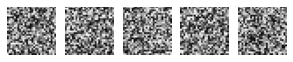

In [3]:
################################################################################
# utils ########################################################################

def plot_sample(x):
        fig = plt.figure(figsize=(5, 25))
        for idx in range(5):
            img = x[idx].cpu().squeeze().detach().numpy()
            ax = fig.add_subplot(1, 5, idx + 1)
            ax.imshow(img, cmap=cm.gray)
            ax.axis('off')
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
        plt.show()

################################################################################


#==============================================================================#
# sanity check ================================================================#
plot_sample(torch.rand(20, 1, 28, 28))
#==============================================================================#

## **Model**
Autoencoder model using CNN layers as encoder and inverse CNN layers for decoder

In [4]:
################################################################################
# variational autoencoder ######################################################


# encoder for autoencoder, CNN based
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(\
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1), \
            nn.ReLU(), \
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), \
            nn.ReLU(), \
            nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0), \
            nn.ReLU(), \
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), \
            nn.ReLU(), \
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0))
        
        self.fc_mu = nn.Sequential(\
            nn.Linear(6 * 6 * 128, 100), \
            nn.ReLU(), \
            nn.Linear(100, 2))
        
        self.fc_logvar = nn.Sequential(\
            nn.Linear(6 * 6 * 128, 100), \
            nn.ReLU(), \
            nn.Linear(100, 2))
        
    def forward(self, x):
        b = x.size(0)
        x = self.conv_layers(x)
        x = x.reshape(b, -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


# decoder for autoencoder
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(\
            nn.Linear(2, 128), \
            nn.SiLU(), \
            nn.Linear(128, 256), \
            nn.SiLU(), \
            nn.Linear(256, 512), \
            nn.SiLU(), \
            nn.Linear(512, 28 * 28))
        
    def forward(self, x):
        b = x.size(0)
        x = self.fc(x)
        x = x.reshape(b, 1, 28, 28)
        x = torch.sigmoid(x)
        return x


# autoencoder
class VAE(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_regen = self.decoder(z)
        return x_regen, z, mu, logvar

    # from mu and logvar from encoder, sample from normal distribution
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    

################################################################################


#==============================================================================#
# sanity check ================================================================#
x = torch.rand(128, 1, 28, 28)
auto = VAE()
x_regen, z, mu, logvar = auto(x)
print('size of encoded latent: ', z.size())
print('size of regenerated image: ', x_regen.size())
#==============================================================================#

size of encoded latent:  torch.Size([128, 2])
size of regenerated image:  torch.Size([128, 1, 28, 28])


## **Train**

epoch  1
reconstruction loss: 63.274
kl loss: 3.180
epoch  2
reconstruction loss: 47.650
kl loss: 1.311
epoch  3
reconstruction loss: 45.253
kl loss: 1.831
epoch  4
reconstruction loss: 41.583
kl loss: 2.788


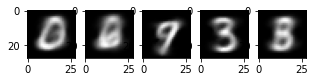

epoch  5
reconstruction loss: 39.268
kl loss: 3.268
epoch  6
reconstruction loss: 37.535
kl loss: 3.594
epoch  7
reconstruction loss: 36.338
kl loss: 3.821
epoch  8
reconstruction loss: 35.626
kl loss: 3.949
epoch  9
reconstruction loss: 35.074
kl loss: 4.052


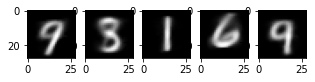

epoch  10
reconstruction loss: 34.644
kl loss: 4.133
epoch  11
reconstruction loss: 34.258
kl loss: 4.204
epoch  12
reconstruction loss: 33.915
kl loss: 4.269
epoch  13
reconstruction loss: 33.603
kl loss: 4.318
epoch  14
reconstruction loss: 33.332
kl loss: 4.374


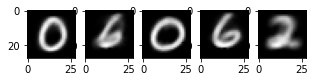

epoch  15
reconstruction loss: 33.071
kl loss: 4.419
epoch  16
reconstruction loss: 32.823
kl loss: 4.474
epoch  17
reconstruction loss: 32.604
kl loss: 4.513
epoch  18
reconstruction loss: 32.402
kl loss: 4.553
epoch  19
reconstruction loss: 32.238
kl loss: 4.583


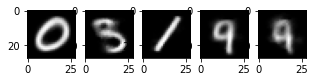

epoch  20
reconstruction loss: 32.070
kl loss: 4.621
epoch  21
reconstruction loss: 31.919
kl loss: 4.653
epoch  22
reconstruction loss: 31.783
kl loss: 4.684
epoch  23
reconstruction loss: 31.653
kl loss: 4.707
epoch  24
reconstruction loss: 31.542
kl loss: 4.724


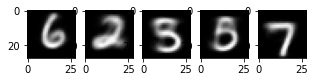

epoch  25
reconstruction loss: 31.431
kl loss: 4.762
epoch  26
reconstruction loss: 31.310
kl loss: 4.773
epoch  27
reconstruction loss: 31.197
kl loss: 4.807
epoch  28
reconstruction loss: 31.129
kl loss: 4.815
epoch  29
reconstruction loss: 31.026
kl loss: 4.841


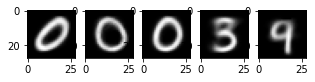

epoch  30
reconstruction loss: 30.935
kl loss: 4.864


In [5]:
################################################################################
# train model ##################################################################

# train single epoch
def train_single_epoch(model, dataloader, idx_epoch):
    model.train().cuda()
    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    epoch_loss, epoch_recon_loss, epoch_kl_loss = 0, 0, 0
    n_data = 0
    # train model
    for imgs, labels in dataloader:
        imgs = imgs.cuda()
        imgs_regen, z, mu, logvar = model(imgs)
        # get loss
        recon_loss = criterion(imgs_regen, imgs)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        # update paramenters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()
        n_data += imgs.size(0)
    # plot regenerated imgs every n epochs
    if idx_epoch % 5 == 0:
        fig = plt.figure(figsize=(5, 30))
        for idx in range(5):
            img = imgs_regen[idx].cpu().squeeze().detach().numpy()
            ax = fig.add_subplot(1, 5, idx + 1)
            ax.imshow(img, cmap=cm.gray)
        plt.show()
    epoch_loss = epoch_loss / n_data
    epoch_recon_loss = epoch_recon_loss / n_data
    epoch_kl_loss = epoch_kl_loss / n_data
    return model, epoch_loss, epoch_recon_loss, epoch_kl_loss

# train model
def train(model, dataloader, n_epoch=50):
    loss_list = []
    model
    for idx_epoch in range(1, n_epoch + 1):
        model, loss, recon_loss, kl_loss = \
                train_single_epoch(model, dataloader, idx_epoch)
        print('epoch ', idx_epoch)
        print('reconstruction loss: {:.3f}'.format(recon_loss))
        print('kl loss: {:.3f}'.format(kl_loss))
    return model

################################################################################


#==============================================================================#
# train model =================================================================#
model = VAE()
trained_vae = train(model, train_loader, n_epoch=30)
#==============================================================================#

## **Plot Latenet Vector**
2 dimensional latenet vector (z) plotted for test dataset. The same labels are in similar latent space. Additionally, compared to AE, the latent vectors of VAE stays in normal distribution of *N*(0,1). This makes VAE to generate images from latent vector

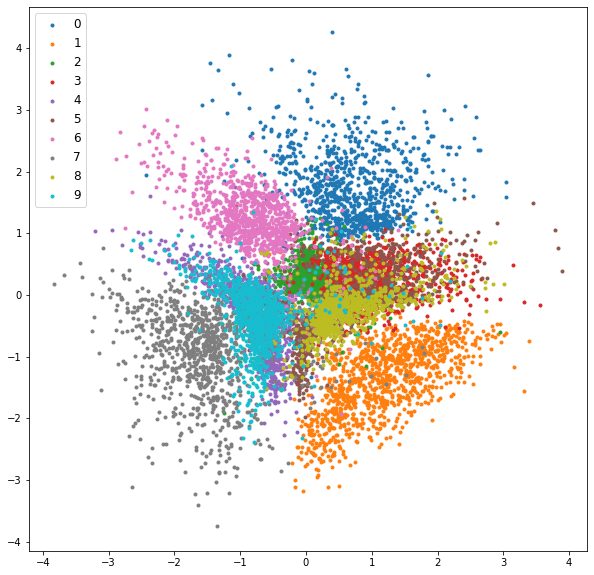

In [6]:
################################################################################
# plot fxns ####################################################################

def plot_scatter(model, loader):
    # get z sampling
    model.cpu().eval()
    z_sampled = []
    label_sampled = []
    for imgs, labels in loader:
        _, z, _, _ = model(imgs)
        z_sampled.append(z) # z[b 2]
        label_sampled.append(labels)
    del imgs
    z_to_plot = torch.cat(z_sampled, dim=0).cpu() # z[n 2]
    label_to_plot = torch.cat(label_sampled, dim=0)
    z_to_plot = z_to_plot[:,:]
    label_to_plot = label_to_plot[:]
    # plot
    x_data = z_to_plot[:,0].squeeze().detach().numpy()
    y_data = z_to_plot[:,1].squeeze().detach().numpy()
    label_data = label_to_plot[:].squeeze().detach().numpy()
    plot_group = [[[],[]] for _ in range(10)]
    for idx in range(len(x_data)):
        label = label_data[idx]
        plot_group[label][0].append(x_data[idx])
        plot_group[label][1].append(y_data[idx])
    plt.figure(figsize=(10,10))
    for number, group in enumerate(plot_group):
        x, y = group
        plt.scatter(x, y, label = str(number), marker='.')
    plt.legend(fontsize=12, loc='upper left')
    plt.show()
    return None
    
################################################################################


#==============================================================================#
# train model =================================================================#
plot_scatter(trained_vae, test_loader)
#==============================================================================#

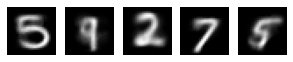

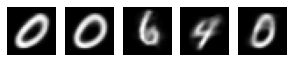

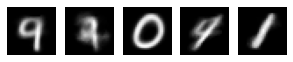

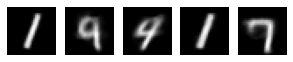

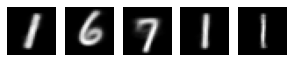

In [7]:
################################################################################
# sampling from N ##############################################################
def sampling(b, z_dim):
    eps = torch.randn(b, z_dim)
    return eps
################################################################################


#==============================================================================#
# plot generated imgs =========================================================#
model = trained_vae
model.eval()
for _ in range(5):
    z = sampling(5, 2)
    img = model.decoder(z)
    plot_sample(img)
#==============================================================================#